In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

In [2]:
def qpsk_symbols(n, seed=0):
    rng = np.random.default_rng(seed)
    bits = rng.integers(0, 2, size=(n, 2))
    mapping = {
        (0,0): 1+1j,
        (0,1): -1+1j,
        (1,1): -1-1j,
        (1,0): 1-1j,
    }
    s = np.array([mapping[tuple(b)] for b in bits], dtype=complex)
    s /= np.sqrt(2)
    return s

def bpsk_symbols(n, seed=0):
    rng = np.random.default_rng(seed)
    b = rng.integers(0, 2, size=n)
    s = (2*b - 1).astype(float)
    return s

def apply_fir_channel(x, h):
    y = np.convolve(x, h, mode="full")[:len(x)]
    return y

def add_awgn(x, snr_db, seed=0):
    rng = np.random.default_rng(seed)
    p = np.mean(np.abs(x)**2)
    snr = 10**(snr_db/10)
    nvar = p / snr
    if np.iscomplexobj(x):
        noise = (rng.normal(0, np.sqrt(nvar/2), size=x.shape) +
                 1j*rng.normal(0, np.sqrt(nvar/2), size=x.shape))
    else:
        noise = rng.normal(0, np.sqrt(nvar), size=x.shape)
    return x + noise

def best_phase_rotation(y, s_ref):
    """
    Corrige a ambiguidade de fase (QPSK): encontra rotação e^{j*phi}
    que minimiza || e^{j*phi} y - s_ref || em LS.
    """
    phi = np.angle(np.vdot(s_ref, y))
    y_rot = y * np.exp(-1j*phi)
    return y_rot, phi

def hard_decision_qpsk(y):
    re = np.where(np.real(y) >= 0, 1.0, -1.0)
    im = np.where(np.imag(y) >= 0, 1.0, -1.0)
    s_hat = (re + 1j*im)/np.sqrt(2)
    return s_hat

def ser_qpsk(s_hat, s_ref):
    return float(np.mean(s_hat != s_ref))

def cm_cost(y, R=1.0):
    return float(np.mean((np.abs(y)**2 - R)**2))

In [3]:
def test_apcm_qpsk(pdf, n=20000, snr_db=25, seed=1,
                  channel=None, filter_order=11, L=2, step_size=0.2, gamma=1e-6,
                  discard=2000, plot=True):
    """
    pdf: seu módulo (ex: import pydaptivefiltering as pdf)
         precisa ter pdf.AffineProjectionCM

    Retorna um dicionário com métricas e arrays.
    """
    if channel is None:
        channel = np.array([0.9+0.0j, 0.4+0.3j, -0.2+0.1j], dtype=complex)

    # 1) sinal
    s = qpsk_symbols(n, seed=seed)
    x = apply_fir_channel(s, channel)
    x = add_awgn(x, snr_db=snr_db, seed=seed+10)

    apcm = pdf.AffineProjectionCM(
        filter_order=filter_order,
        step_size=step_size,
        memory_length=L,
        gamma=gamma,
        w_init=None
    )
    apcm.w[:] = 0
    apcm.w[0] = 1.0 + 0j

    res = apcm.optimize(x, verbose=True)
    y = res.outputs

    s_eval = s[discard:]
    y_eval = y[discard:]

    y_rot, phi = best_phase_rotation(y_eval, s_eval)
    s_hat = hard_decision_qpsk(y_rot)

    out = {
        "ser": ser_qpsk(s_hat, s_eval),
        "cm_cost": cm_cost(y_eval, R=1.0),
        "phi": phi,
        "y": y,
        "x": x,
        "s": s,
        "y_rot_eval": y_rot,
        "s_hat_eval": s_hat,
        "res": res,
    }

    if plot:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(10*np.log10(np.abs(res.errors)**2 + 1e-12))
        plt.title("AP-CM: curva (|e|^2) em dB")
        plt.xlabel("n"); plt.grid(True, alpha=0.3)

        plt.subplot(1,2,2)
        plt.scatter(np.real(y_rot[:4000]), np.imag(y_rot[:4000]), s=2)
        plt.title("Constelação equalizada (após rotação)")
        plt.axis("equal"); plt.grid(True, alpha=0.3)
        plt.show()

        print(f"SER (após warm-up): {out['ser']:.4e}")
        print(f"CM cost (após warm-up): {out['cm_cost']:.4e}")
        print(f"Fase estimada (rad): {out['phi']:.3f}")

    return out


[AffineProjectionCM] Completed in 323.54 ms


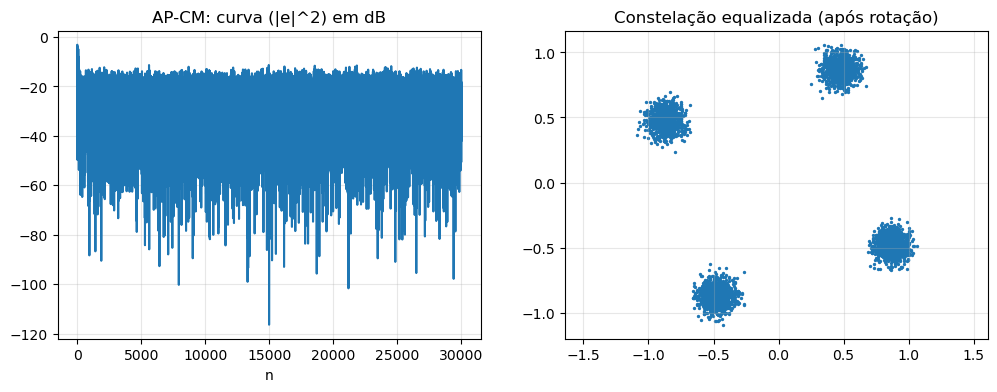

SER (após warm-up): 4.9874e-01
CM cost (após warm-up): 1.8926e-02
Fase estimada (rad): -1.655


In [4]:
out = test_apcm_qpsk(
    pdf,
    n=30000,
    snr_db=25,
    filter_order=11,
    L=2,
    step_size=0.15,
    gamma=1e-6,
    discard=3000,
    plot=True
)